Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

И сделать это можно с помощью модели, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы (вот она, сила ML!). Чтобы определиться с параметрами будущей модели, проведите разведывательный анализ данных и составьте отчёт по его результатам.

- Проведите первичную обработку данных. Так как данных много, стоит написать функции, которые можно применять к столбцам определённого типа.
- Посмотрите на распределение признака для числовых переменных, устраните выбросы.
- Оцените количество уникальных значений для номинативных переменных.
- По необходимости преобразуйте данные
- Проведите корреляционный анализ количественных переменных
- Отберите не коррелирующие переменные.
- Проанализируйте номинативные переменные и устраните те, которые не влияют на предсказываемую величину (в нашем случае — на переменную score).
- Не забудьте сформулировать выводы относительно качества данных и тех переменных, которые вы будете использовать в дальнейшем построении модели.

Вот по каким критериям проект будет оценивать ментор:

1. Качество кода и соответствие стандартам оформления pep-8.
2. Для каждого столбца найдено количество пустых строк, найдены и убраны выбросы. 
3. Для количественных переменных построены гистограммы распределений и сделаны выводы.
4. Проведён корреляционный анализ и анализ номинативных переменных, корректно отобраны переменные для построения модели.
5. Сформулированы промежуточные и итоговые выводы.

In [1648]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

import random

import warnings
warnings.filterwarnings("ignore")


In [1649]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

#### Используемые функции

In [1650]:
def creat_list_for_filling_gaps(column):
    """Функция для создания списка элементов при пропорциональном заполнении пропусков"""
    
    value_counts = column.value_counts()[0] + column.value_counts()[1]
    isna_counts = column.isna().sum()
    
    list_of_values = [column.value_counts().index[0]]  * int(round(column.value_counts()[0] / value_counts * isna_counts)) + \
                     [column.value_counts().index[1]]  * int(round(column.value_counts()[1] / value_counts * isna_counts))
    
    random.shuffle(list_of_values)
    
    return list_of_values

def filling_gaps_proportionally(column):
    """Функция для пропорционального заполнения пропусков""" 
    
    list_of_values = creat_list_for_filling_gaps(column)
    
    column[column.isna()] = list_of_values
    
    return column

In [1651]:
def initial_description(column, bins=10):
    """Функция для вывода начального описания ординального признака""" 
    
    math[column].hist(bins=bins)
    plt.suptitle(f'Distribution of {column} variable')
    print("Уникальных значений:", math[column].nunique())
    print('Пропуски: ', math[column].isna().sum())
    display(math[column].describe())
    
def initial_description_nominal(column, bins=10):
    """Функция для вывода начального описания номинального признака""" 
    
    math[column].hist(bins=bins)
    plt.suptitle(f'Distribution of {column} variable')
    print('Пропуски: ', math[column].isna().sum())
    display(math[column].describe())    

In [1652]:
def get_boxplot(column):
    """Функция отрисовки boxplot по одному признаку"""
    
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=math,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
def get_stat_dif(column):
    """Функция проверки гипотезы о том, что распределения оценок по различным параметрам неразличимы"""
    
    cols = math.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(math.loc[math.loc[:, column] == comb[0], 'score'], 
                     math.loc[math.loc[:, column] == comb[1], 'score']).pvalue \
                     <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break    

#### Чтение и первичный просмотр данных

In [1653]:
math = pd.read_csv('stud_math.csv')

In [1654]:
display(math.head(10))
math.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

1 school — аббревиатура школы, в которой учится ученик

2 sex — пол ученика ('F' - женский, 'M' - мужской)

3 age — возраст ученика (от 15 до 22)

4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)

6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 failures — количество внеучебных неудач (n, если 1<=n<3, иначе 0)

16 schoolsup — дополнительная образовательная поддержка (yes или no)

17 famsup — семейная образовательная поддержка (yes или no)

18 paid — дополнительные платные занятия по математике (yes или no)

19 activities — дополнительные внеучебные занятия (yes или no)

20 nursery — посещал детский сад (yes или no)

21 higher — хочет получить высшее образование (yes или no)

22 internet — наличие интернета дома (yes или no)

23 romantic — в романтических отношениях (yes или no)

24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 absences — количество пропущенных занятий

29 score — баллы по госэкзамену по математике

#### Будем рассматривать признаки по отдельности в следующем порядке
1. Числовые (количественные), таких немного: age, absences и целевая переменная score
2. Категориальные (номинальные и бинарные) и ординальные (порядковые)


### score — баллы по госэкзамену по математике (целевая переменная)

In [1655]:
math.score.isna().sum()

6

In [1656]:
math.dropna(axis=0, subset=['score'], inplace=True) # удаляем строки с пропусками, так как score - это целевая переменная.

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

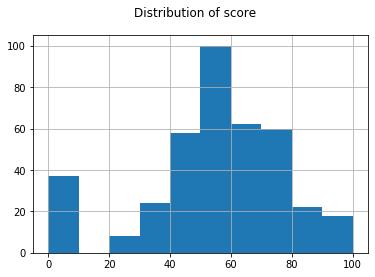

In [1657]:
math.score.hist()
plt.suptitle('Distribution of score')
math.score.describe()

Большинство оценок распределены между 20 и 100 (распределены нормально), и часть оценок равна 0.

Скорее всего 0 баллов означает неявку ученика на экзамен или его отстранение.

При обучении модели стоит попробовать удалить строки с 0 (так как неявка может быть не связана с успеваемостью ученика) и сравнить оценки работы алгоритма на тестовой выборке. Пока удалять не будем.

Выделять в отдельный признак оценки равные 0 не имеет смысла, так как на новых данных значения score будут не известны, и признак не будет заполняться.


### age — возраст ученика (от 15 до 22)

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

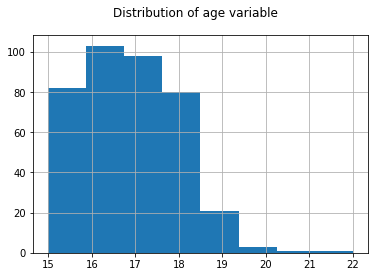

In [1658]:
math.age.hist(bins=8)
plt.suptitle('Distribution of age variable')
math.age.describe()

Пропусков нет. Выбросов нет. Видно, что основная часть учеников распределена между 15 и 18 годами, с увеличением возраста количество учеников сильно уменьшается.

### absences — количество пропущенных занятий

Пропуски:  11


count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

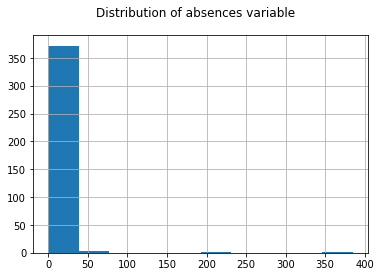

In [1659]:
print('Пропуски: ', math.absences.isna().sum())
hist = math.absences.hist()
plt.suptitle('Distribution of absences variable')
math.absences.describe()

В данных есть пропуски, возможно есть выбросы. Посмотрим подробнее:

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


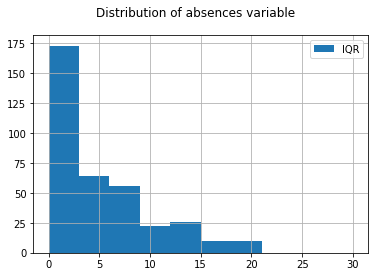

In [1660]:
median = math.absences.median()
IQR = math.absences.quantile(0.75) - math.absences.quantile(0.25)
perc25 = math.absences.quantile(0.25)
perc75 = math.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
math.absences.loc[math.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 30), label = 'IQR')
plt.suptitle('Distribution of absences variable')
plt.legend();

In [1661]:
math.loc[math.absences > 20] # Посмотрим на данные с выбросами

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,-6.0,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


Удалять все выбросы сразу не хочется, так как есть сомнения в том, что это действительно выбросы (при большом количестве (30-50) результаты за экзамен очень не высоки), а может много пропусков означают проблемы со здоровьем или еще что-нибудь, что тоже может быть важно для анализа.

Для начала, удалим только строки с экстремально высокими значениями (> 100), а при обучении модели можно поэксперементировать (удалить больше, заменить медианой?)

Пропуски заполним 0, так как логично предположить, что значение не заполнено, так как нечего было указывать, и 0 является самым частым значением.

In [1662]:
math.absences.fillna(math.absences.mode()[0], inplace=True)
math = math.loc[math.absences < 100] 

In [1663]:
math.absences.mode()

0    0.0
dtype: float64

### school — аббревиатура школы, в которой учится ученик

In [1664]:
display(pd.DataFrame(math.school.value_counts(dropna=False)))

,school
GP,343
MS,44


2 уникальных значения, выбросов и пропусков нет.

Преобразуем данные: GP - 0, MS - 1

In [1665]:
map_dict = {'GP': 0, 'MS': 1}
math['school'] = math['school'].map(map_dict)

Text(0.5, 0.98, 'Distribution of address variable')

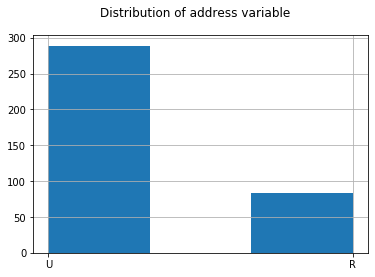

In [1666]:
math.address.hist(bins=3)
plt.suptitle('Distribution of address variable')

### sex — пол ученика ('F' - женский, 'M' - мужской)

In [1667]:
display(pd.DataFrame(math.sex.value_counts(dropna=False)))

,sex
F,203
M,184


2 уникальных значения, выбросов и пропусков нет.

Преобразуем данные: F - 0, M - 1

In [1668]:
map_dict = {'F': 0, 'M': 1}
math['sex'] = math['sex'].map(map_dict)

Text(0.5, 0.98, 'Distribution of sex variable')

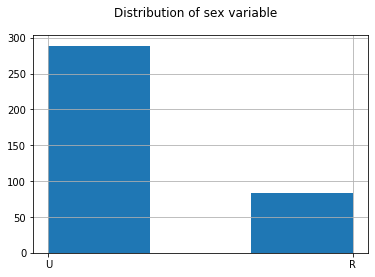

In [1669]:
math.address.hist(bins=3)
plt.suptitle('Distribution of sex variable')

### address — тип адреса ученика ('U' - городской, 'R' - за городом)

In [1670]:
display(pd.DataFrame(math.address.value_counts(dropna=False)))

,address
U,289
R,83
NaN,15


2 уникальных значения, выбросов нет.

15 пропусков (~3%) заполним Модой (U)

Преобразуем данные: U - 0, R - 1

In [1671]:
math.address.fillna(math.address.mode()[0], inplace=True)
map_dict = {'U': 0, 'R': 1}
math['address'] = math['address'].map(map_dict)

Text(0.5, 0.98, 'Distribution of address variable')

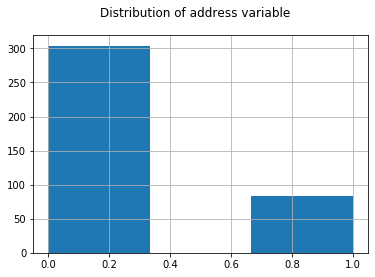

In [1672]:
math.address.hist(bins=3)
plt.suptitle('Distribution of address variable')

### famsize — размер семьи('LE3' <= 3, 'GT3' >3)


In [1673]:
display(pd.DataFrame(math.famsize.value_counts(dropna=False)))

,famsize
GT3,254
LE3,106
NaN,27


2 уникальных значения, выбросов нет.

27 пропусков (~6%) заполним пропорционально (чтобы не сбивать распределение), при обучении можно попробовать другие способы и сравнить результаты

Преобразуем данные: GT3 - 0, LE3 - 1

In [1674]:
math.famsize = filling_gaps_proportionally(math.famsize)
map_dict = {'GT3': 0, 'LE3': 1}
math['famsize'] = math['famsize'].map(map_dict)

Text(0.5, 0.98, 'Distribution of famsize variable')

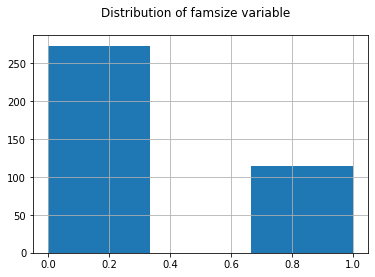

In [1675]:
math.famsize.hist(bins=3)
plt.suptitle('Distribution of famsize variable')

### Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [1676]:
display(pd.DataFrame(math.Pstatus.value_counts(dropna=False)))

,Pstatus
T,307
NaN,45
A,35


2 уникальных значения, выбросов нет.

Пропуски (~12%) заполним Модой (T)

Преобразуем данные: T - 0, A - 1

In [1677]:
math.Pstatus.fillna(math.Pstatus.mode()[0], inplace=True)
map_dict = {'T': 0, 'A': 1}
math['Pstatus'] = math['Pstatus'].map(map_dict)

Text(0.5, 0.98, 'Distribution of Pstatus variable')

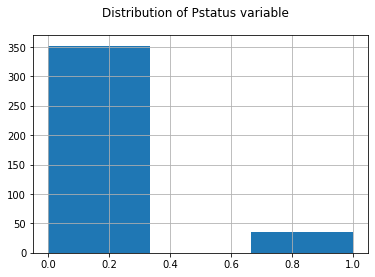

In [1678]:
math.Pstatus.hist(bins=3)
plt.suptitle('Distribution of Pstatus variable')

Процент значения A (0) в данных составляет всего 9%, возможно, этот признак не является информативным, и его не стоит брать в модель

### schoolsup — дополнительная образовательная поддержка (yes или no)

In [1679]:
column = 'schoolsup'

In [1680]:
display(pd.DataFrame(math[column].value_counts(dropna=False)))

,schoolsup
no,330
yes,48
NaN,9


2 уникальных значения, выбросов нет.

Пропуски (~2%) заполним Модой (no)

Преобразуем данные: no - 0, yes - 1

In [1681]:
math[column].fillna(math[column].mode()[0], inplace=True)
dict_yes_no = {'no': 0, 'yes': 1}
math[column] = math[column].map(dict_yes_no)

Text(0.5, 0.98, 'Distribution of schoolsup variable')

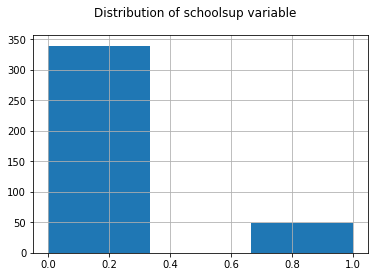

In [1682]:
math[column].hist(bins=3)
plt.suptitle(f'Distribution of {column} variable')

### famsup — семейная образовательная поддержка (yes или no)

In [1683]:
column = 'famsup'

In [1684]:
display(pd.DataFrame(math[column].value_counts(dropna=False)))

,famsup
yes,215
no,135
NaN,37


2 уникальных значения, выбросов нет.

Пропуски (~10%) заполним пропорционально (чтобы не сбивать распределение), при обучении можно попробовать другие способы (Мода, удаление) и сравнить результаты

Преобразуем данные: no - 0, yes - 1

In [1685]:
math[column] = filling_gaps_proportionally(math[column])
math[column] = math[column].map(dict_yes_no)

Text(0.5, 0.98, 'Distribution of famsup variable')

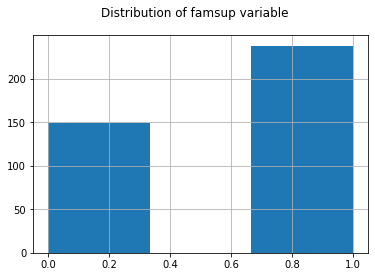

In [1686]:
math[column].hist(bins=3)
plt.suptitle(f'Distribution of {column} variable')

### paid — дополнительные платные занятия по математике (yes или no)

In [1687]:
column = 'paid'

In [1688]:
display(pd.DataFrame(math[column].value_counts(dropna=False)))

,paid
no,196
yes,152
NaN,39


2 уникальных значения, выбросов нет.

Рассмотрим пропуски (~10%). Посмотрим на распределение признака paid в зависимости от признака famsup

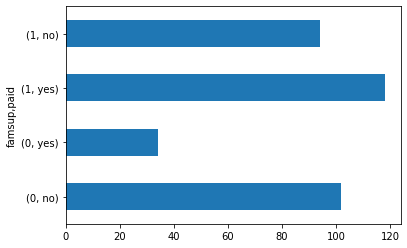

In [1689]:
math.groupby(math.famsup).paid.value_counts().plot(kind = 'barh')

По графику видно. что если ученику не оказывается семейная образовательная поддержка, то и вероятность платных занятий мала. 
Заполним пропуски paid на основании famsup: Если famsup = no, то paid = no, иначе paid = yes. Можно еще усложнять и заполнять значения пропорционально, если famsup = yes. Или, наоборот, не усложнять и заполнить просто Модой, это стоит проверить при обучении модели.   

In [1690]:
math.paid = math.apply(lambda x: ('no' if x.famsup == 0 else 'yes') if pd.isna(x.paid) else x.paid , axis=1)

Преобразуем данные: no - 0, yes - 1

In [1691]:
math[column] = math[column].map(dict_yes_no)

Text(0.5, 0.98, 'Distribution of paid variable')

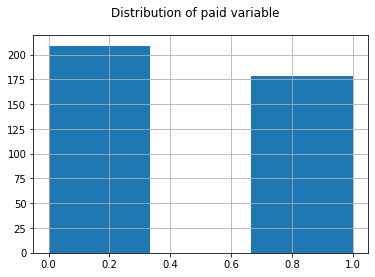

In [1692]:
math[column].hist(bins=3)
plt.suptitle(f'Distribution of {column} variable')

### activities — дополнительные внеучебные занятия (yes или no)

In [1693]:
column = 'activities'

In [1694]:
display(pd.DataFrame(math[column].value_counts(dropna=False)))

,activities
yes,192
no,181
NaN,14


2 уникальных значения, выбросов нет.

Пропуски (~4%) заполним Модой (yes).

Преобразуем данные: no - 0, yes - 1

In [1695]:
math[column].fillna(math[column].mode()[0], inplace=True)
math[column] = math[column].map(dict_yes_no)

Text(0.5, 0.98, 'Distribution of activities variable')

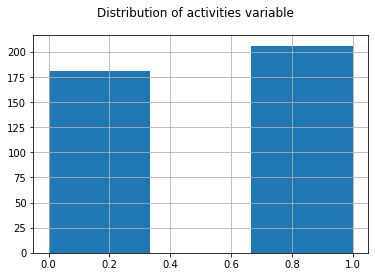

In [1696]:
math[column].hist(bins=3)
plt.suptitle(f'Distribution of {column} variable')

### nursery — посещал детский сад (yes или no)

In [1697]:
column = 'nursery'

In [1698]:
display(pd.DataFrame(math[column].value_counts(dropna=False)))

,nursery
yes,295
no,77
NaN,15


2 уникальных значения, выбросов нет.

Пропуски (~4%) заполним Модой (yes).

Преобразуем данные: no - 0, yes - 1

In [1699]:
math[column].fillna(math[column].mode()[0], inplace=True)
math[column] = math[column].map(dict_yes_no)

Text(0.5, 0.98, 'Distribution of nursery variable')

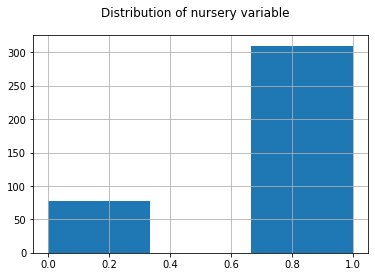

In [1700]:
math[column].hist(bins=3)
plt.suptitle(f'Distribution of {column} variable')

### higher — хочет получить высшее образование (yes или no)

In [1701]:
column = 'higher'

In [1702]:
display(pd.DataFrame(math[column].value_counts(dropna=False)))

,higher
yes,348
NaN,20
no,19


2 уникальных значения, выбросов нет.

Пропуски (~5%) заполним Модой (yes).

Преобразуем данные: no - 0, yes - 1

In [1703]:
math[column].fillna(math[column].mode()[0], inplace=True)
math[column] = math[column].map(dict_yes_no)

Text(0.5, 0.98, 'Distribution of higher variable')

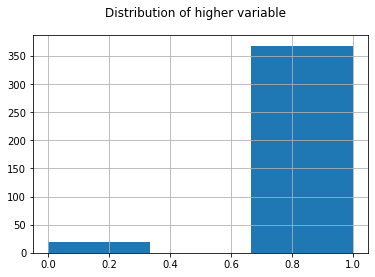

In [1704]:
math[column].hist(bins=3)
plt.suptitle(f'Distribution of {column} variable')

Процент значения no (0) в данных составляет всего 5%, возможно, этот признак не является информативным, и его не стоит брать в модель. Или, наоборот, те, кто не хочет вышку, не особо и стараются? Посмотрим при дальнейшем анализе

### internet — наличие интернета дома (yes или no)

In [1705]:
column = 'internet'

In [1706]:
display(pd.DataFrame(math[column].value_counts(dropna=False)))

,internet
yes,299
no,54
NaN,34


2 уникальных значения, выбросов нет.

Пропуски (~9%) заполним Модой (yes). В дальнейшем, если признак окажется информативным, можно попробовать заполнить его на основании адреса (в городе интернет есть почти у всех)

Преобразуем данные: no - 0, yes - 1

In [1707]:
math[column].fillna(math[column].mode()[0], inplace=True)
math[column] = math[column].map(dict_yes_no)

Text(0.5, 0.98, 'Distribution of internet variable')

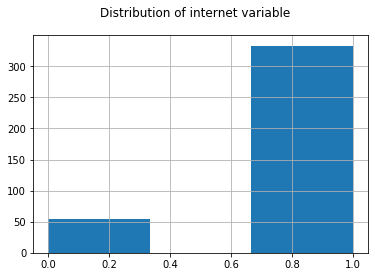

In [1708]:
math[column].hist(bins=3)
plt.suptitle(f'Distribution of {column} variable')

### romantic — в романтических отношениях (yes или no)

In [1709]:
column = 'romantic'

In [1710]:
display(pd.DataFrame(math[column].value_counts(dropna=False)))

,romantic
no,233
yes,123
NaN,31


2 уникальных значения, выбросов нет.

Пропуски (~8%) заполним Модой (no).

Преобразуем данные: no - 0, yes - 1

In [1711]:
math[column].fillna(math[column].mode()[0], inplace=True)
math[column] = math[column].map(dict_yes_no)

Text(0.5, 0.98, 'Distribution of romantic variable')

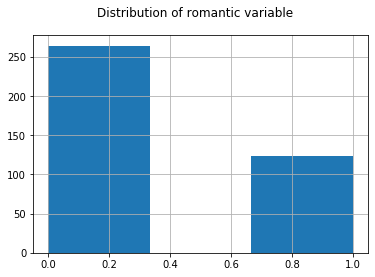

In [1712]:
math[column].hist(bins=3)
plt.suptitle(f'Distribution of {column} variable')

### Mjob — работа матери

Пропуски:  19


count       368
unique        5
top       other
freq        127
Name: Mjob, dtype: object

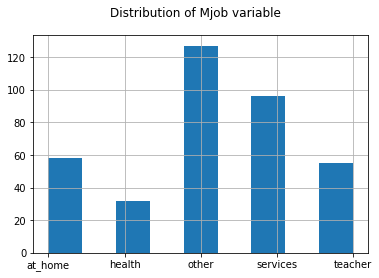

In [1713]:
column = 'Mjob'
initial_description_nominal(column, 9)

5 уникальных значений, выбросов нет.

Видно, что Модой является значение 'other', то есть чаще точная профессия остается неизвестной.

Пропущеных значение немного (~5%), поэтому выделять их в отдельныю категорию не будем, а заполним модой. 


In [1714]:
math[column].fillna(math[column].mode()[0], inplace=True)

Так как признак является категориальным, то преобразовывать его значения в числа неверно. В дальнейшем проверим является ли признак значимым, и если да, то перекодируем его с помощью "get_dummies"

### Fjob — работа отца

Пропуски:  36


count       351
unique        5
top       other
freq        194
Name: Fjob, dtype: object

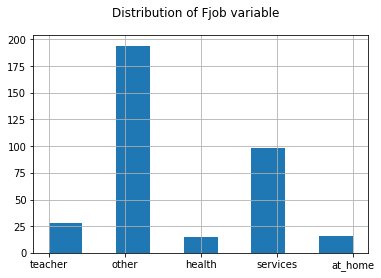

In [1715]:
column = 'Fjob'
initial_description_nominal(column, 9)

Признак аналогичен признаку Mjob, только значение 'other' встречается еще чаще, возможно,  значение этого признака для модели будет невелико.

In [1716]:
math[column].fillna(math[column].mode()[0], inplace=True)

### reason — причина выбора школы

Пропуски:  17


count        370
unique         4
top       course
freq         134
Name: reason, dtype: object

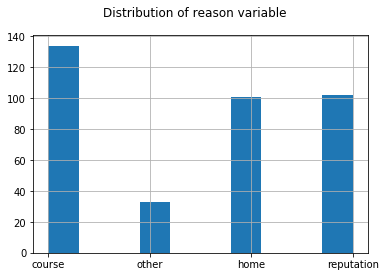

In [1717]:
column = 'reason'
initial_description_nominal(column)

4 уникальных значения, выбросов нет.

Пропущеных значение немного (~4%), поэтому выделять их в отдельныю категорию не будем. Для начала заполним пропуски значением 'other' (по смыслу), при обучении можно попробовать другие способы: мода, медиана?

In [1718]:
math[column].fillna('other', inplace=True)

Так как признак является категориальным, то преобразовывать его значения в числа неверно. В дальнейшем проверим является ли признак значимым, и если да, то перекодируем его с помощью "get_dummies"

### guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

Пропуски:  30


count        357
unique         3
top       mother
freq         247
Name: guardian, dtype: object

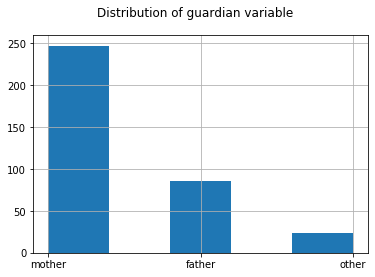

In [1719]:
column = 'guardian'
initial_description_nominal(column, 5)

3 уникальных значения, выбросов нет. Преобладает значение 'mother' (~64%).

Пропущеных значение не очень много (~8%), поэтому выделять их в отдельныю категорию не будем. Для начала заполним пропуски значением 'mother' (модой).

In [1720]:
math[column].fillna(math[column].mode()[0], inplace=True)

Так как признак является категориальным, то преобразовывать его значения в числа неверно. В дальнейшем проверим является ли признак значимым, и если да, то перекодируем его с помощью "get_dummies"

### Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Уникальных значений: 5
Пропуски:  3


count    384.000000
mean       2.770833
std        1.095723
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

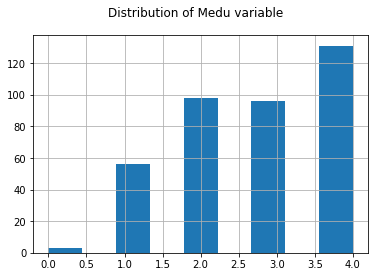

In [1721]:
column = 'Medu'
initial_description(column, 9)

5 уникальных значений, выбросов нет. Можно заметить, что матерей без образования практически нет.

Пропусков всего 3, заполним их медианой (3).

In [1722]:
math[column].fillna(math[column].median(), inplace=True)

### Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Уникальных значений: 6
Пропуски:  24


count    363.000000
mean       2.628099
std        2.247647
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

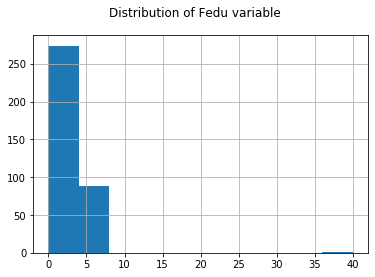

In [1723]:
column = 'Fedu'
initial_description(column)

Видно, что есть выброс = 40, такого значения явно не предполагалось.
Для его удаления предположим, что это опечатка, и заменим значение на 4.

In [1724]:
math.Fedu[math.Fedu == 40] = 4

Уникальных значений: 5
Пропуски:  24


count    363.000000
mean       2.528926
std        1.090449
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

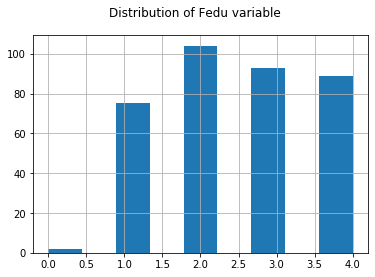

In [1725]:
initial_description(column, 9)

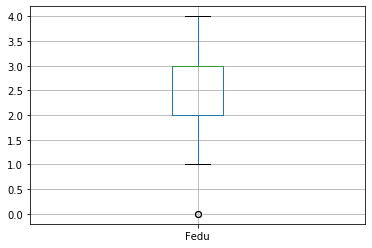

In [1726]:
math.boxplot(column='Fedu')

5 уникальных значений, и по статистике теперь получается, что значение 0 является выбросом? По логике это значение имеет место быть, понятно, что оно означает, и это не ошибка, но таких строк всего 2, но может быть больше в новых данных. 

На этом этапе не будем ничего удалять, но на этапе обучения стоит попробовать преобразовать признак и сделать только 2 значения: до 9 класса включительно, и 11 классов и выше, или есть образование - нет образования 

Пропусков ~6%, на данном этапе заполним медианой (3). Стоит попробовать пропорциональное заполнение или выделить в отдельную категорию вместе с 0?

In [1727]:
math[column].fillna(math[column].median(), inplace=True)

Text(0.5, 0.98, 'Distribution of Fedu variable')

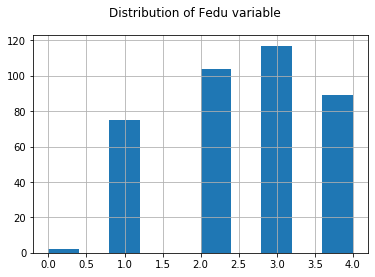

In [1728]:
math[column].hist()
plt.suptitle(f'Distribution of {column} variable')

В результате анализа влияния признаков на целевую переменную было принято решение преобразовать признак. Сделать только 2 значения: 0 - нет образования, 1 - есть образование.

In [1729]:
math.Fedu = math.Fedu.apply(lambda x: 0 if x == 0 else 1)

### traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Уникальных значений: 4
Пропуски:  28


count    359.000000
mean       1.437326
std        0.693827
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

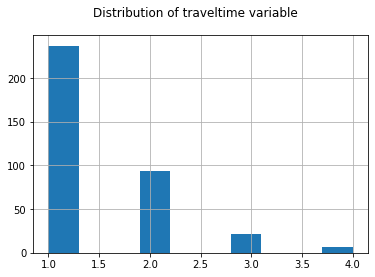

In [1730]:
column = 'traveltime'
initial_description(column)

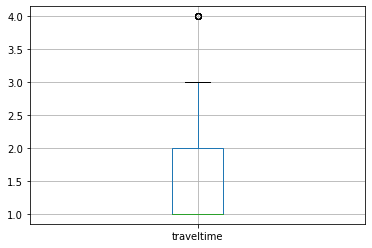

In [1731]:
math.boxplot(column=column)

4 уникальных значений, выбросов нет (по логике). Хотя по статистике число 4 опять под вопросом. Заметим, что большинство учеников проживает недалеко от школ, и чем дальше, тем меньше.

Пропусков ~7%, заполним медианой (1).

In [1732]:
math[column].fillna(math[column].median(), inplace=True)

Text(0.5, 0.98, 'Distribution of traveltime variable')

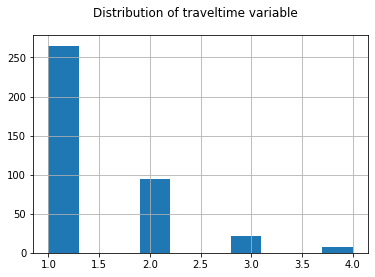

In [1733]:
math[column].hist()
plt.suptitle(f'Distribution of {column} variable')

### studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

Уникальных значений: 4
Пропуски:  7


count    380.000000
mean       2.036842
std        0.849467
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

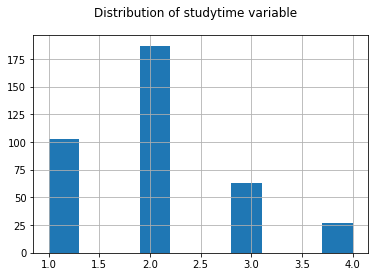

In [1734]:
column = 'studytime'
initial_description(column)

4 уникальных значений, выбросов нет (по логике).

Пропуски ~2% заменим медианой (2).

In [1735]:
math[column].fillna(math[column].median(), inplace=True)

В результате анализа влияния признаков на целевую переменную было принято решение преобразовать признак. Сделаем только 2 значения: 0 - до 5 часов, 1 - больше 5 часов. После такого преобразования признак подходит по статистике.

In [1736]:
math.studytime = math.studytime.apply(lambda x: 0 if (x == 1 or x == 2)  else 1)

### studytime, granular - ?

Уникальных значений: 4
Пропуски:  7


count    380.000000
mean      -6.110526
std        2.548401
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64

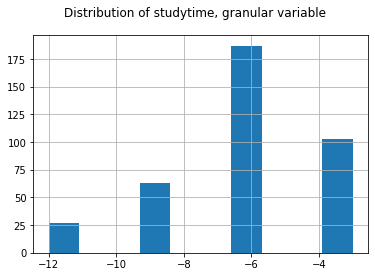

In [1737]:
column = 'studytime, granular'
initial_description(column)

4 уникальных значения. 

Часть названия признака и его распределение совпадают с признаком studytime, отличаются только значения. Проверим:

In [1738]:
math.groupby(math.studytime)[column].value_counts()

studytime  studytime, granular
0          -6.0                   187
           -3.0                   103
1          -9.0                    63
           -12.0                   27
Name: studytime, granular, dtype: int64

каждому значению признака "studytime" соответствует ровно одно значение "studytime, granular", то есть признак является дублем.

Дальше его рассматривать не будем

### failures — количество внеучебных неудач (n, если 1<=n<3, иначе 0)

Уникальных значений: 4
Пропуски:  22


count    365.000000
mean       0.323288
std        0.725993
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

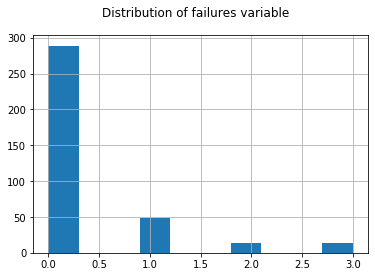

In [1739]:
column = 'failures'
initial_description(column)

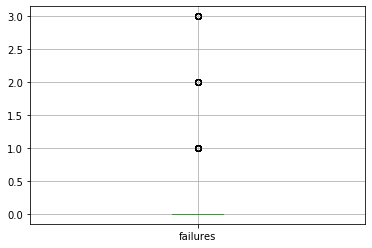

In [1740]:
math.boxplot(column=column)

4 уникальных значения, но на 75% данные заполнены 0. По статистике все значения кроме 0 являются выбросами. При этом не понятно, что означает 0. Это 0 неудач или больше 3х неудач? Если и то и другое, то признак точно не имеет смысла. 
Скрытый пропуск? Посмотрим влияет ли признак на целевую переменную при дальнейшем анализе. Может стоит разбить всего на 2 значения: 0 и объединить все остальные

Пропуски (~6%) заполним 0, это и Мода и Медиана.

In [1741]:
math[column].fillna(math[column].median(), inplace=True)

### famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

Уникальных значений: 6
Пропуски:  27


count    360.000000
mean       3.933333
std        0.926851
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

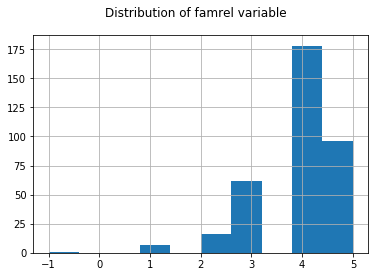

In [1742]:
column = 'famrel'
initial_description(column)

Видно, что есть выброс = -1, такого значения явно не предполагалось. Для его удаления предположим, что это опечатка, и заменим значение на 1. Но можно еще удалить эту строку.

Пропуски (~7%) заполним по пропорции между 2 самыми популярными значениями (4 и 5), чтобы не очень сбить распределение.

In [1743]:
math.famrel[math.famrel == -1] = 1

In [1744]:
math[column].value_counts()

4.0    178
5.0     96
3.0     62
2.0     16
1.0      8
Name: famrel, dtype: int64

In [1745]:
list_of_values = [4.0]  * int(round(171 / 266 * 27)) + [5.0]  * int(round(95 / 266 * 27))
random.shuffle(list_of_values)
math.famrel[math.famrel.isna()] = list_of_values

Text(0.5, 0.98, 'Distribution of famrel variable')

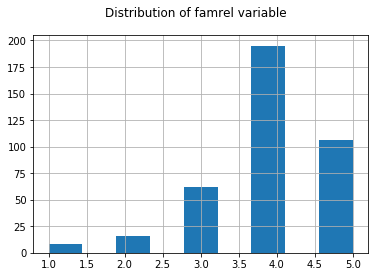

In [1746]:
math[column].hist(bins=9)
plt.suptitle(f'Distribution of {column} variable')

### freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

Уникальных значений: 5
Пропуски:  9


count    378.000000
mean       3.219577
std        0.991710
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

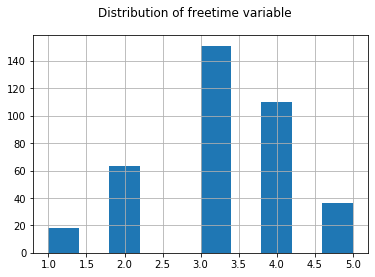

In [1747]:
column = 'freetime'
initial_description(column)

5 уникальных значений, выбросов нет.

Пропуски ~2% заменим медианой (и модой).

In [1748]:
math[column].fillna(math[column].median(), inplace=True)

### goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

Уникальных значений: 5
Пропуски:  7


count    380.000000
mean       3.097368
std        1.112886
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

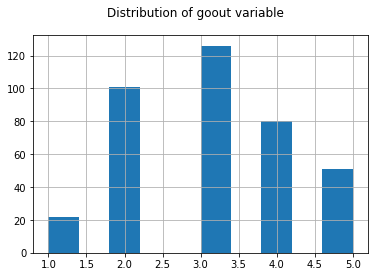

In [1749]:
column = 'goout'
initial_description(column)

5 уникальных значений, выбросов нет.

Пропуски ~2% заменим медианой (и модой).

In [1750]:
math[column].fillna(math[column].median(), inplace=True)

### health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

Уникальных значений: 5
Пропуски:  15


count    372.000000
mean       3.529570
std        1.405299
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

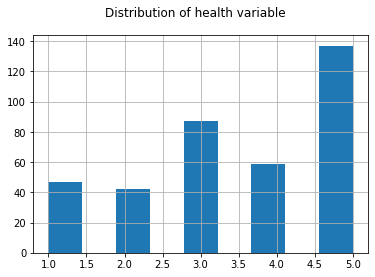

In [1751]:
column = 'health'
initial_description(column, 9)

5 уникальных значений, выбросов нет.

Пропуски ~4% заменим медианой (4).

In [1752]:
math[column].fillna(math[column].median(), inplace=True)

## Корреляционный анализ
Корреляции рассмотрим только для числовых столбцов.

In [1753]:
numeric_columns = ['age', 'absences', 'score']
numeric_data = math[numeric_columns]

Используем для наглядности матрицу корреляций:

,age,absences,score
age,1.000000,0.168017,-0.153488
absences,0.168017,1.000000,0.023926
score,-0.153488,0.023926,1.000000


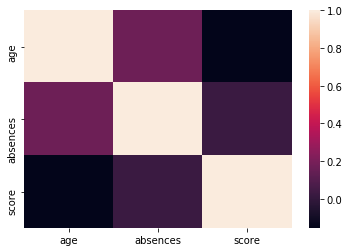

In [1754]:
sns.heatmap(numeric_data.corr())
numeric_data.corr()

У нас есть две слабоскоррелированные со score переменные: age и absences, которые между собой тоже слабоскоррелированы.

Интересно, что корреляция параметра age и score отрицательная. Это говорит о том, что с возрастом экзамен сдается хуже.

Признаки age и absences остаются в модели.

## Анализ номинативных переменных

Очевидно, что для номинативных переменных использовать корреляционный анализ не получится. Однако можно посмотреть, различаются ли распределения рейтинга в зависимости от значения этих переменных. Это можно сделать, например, с помощью box-plot 

In [1755]:
nominative_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 
                      'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'Mjob', 
                      'Fjob', 'reason', 'guardian', 'Medu', 'Fedu', 'traveltime', 'studytime',
                      'failures', 'famrel', 'freetime', 'goout', 'health'
                     ]

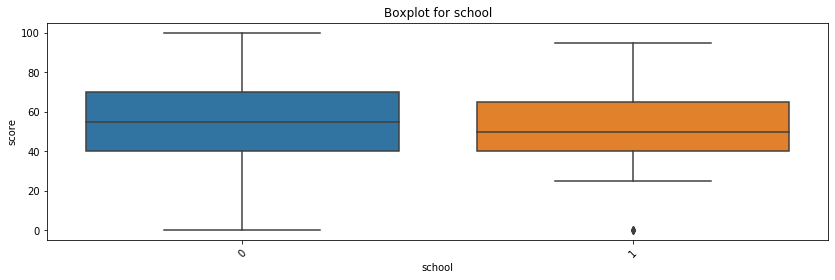

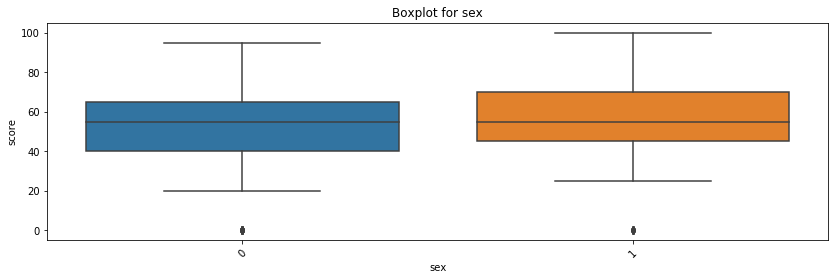

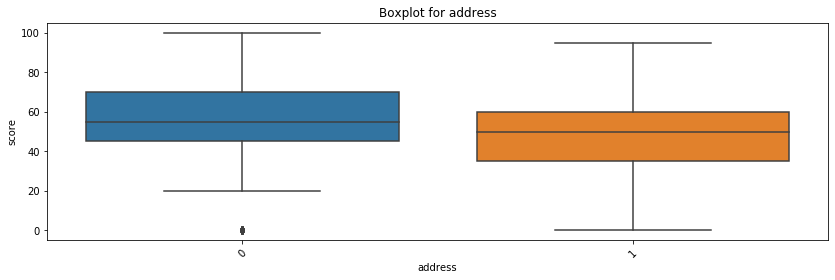

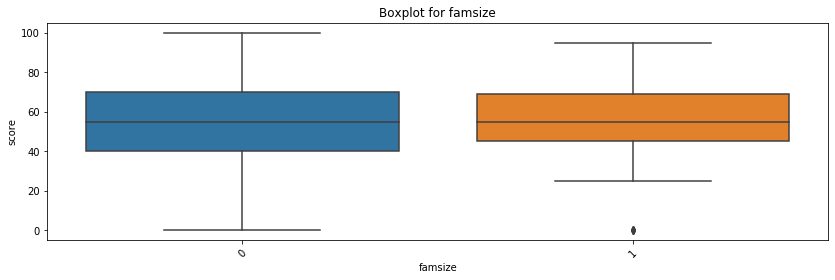

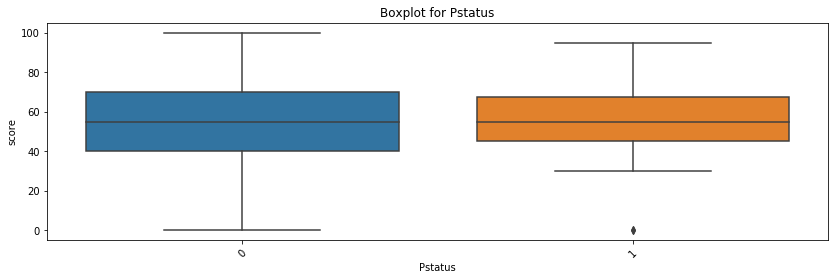

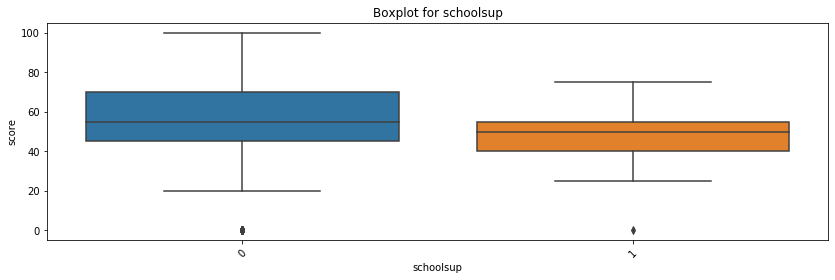

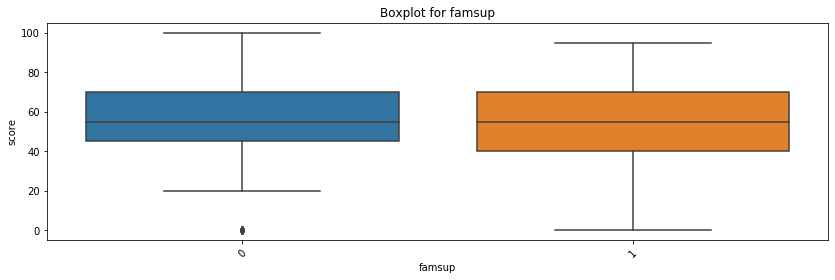

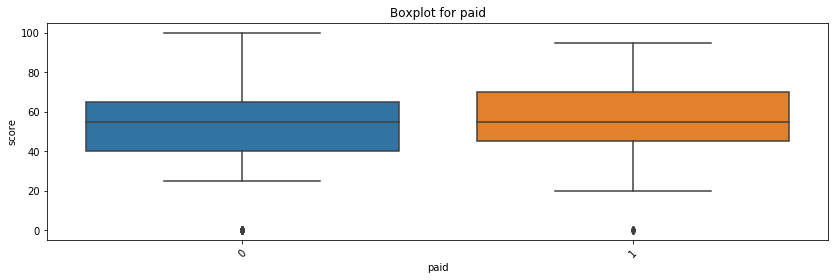

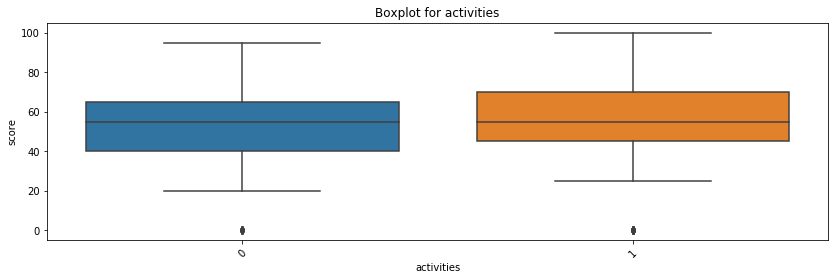

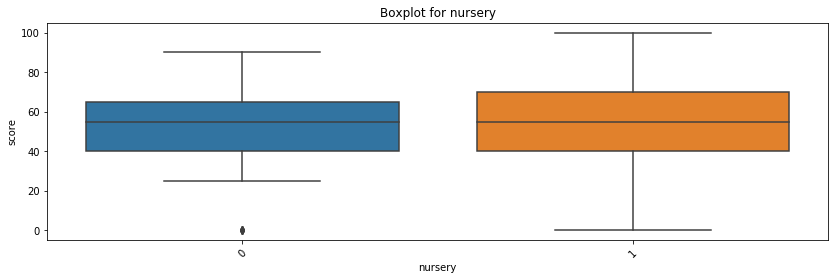

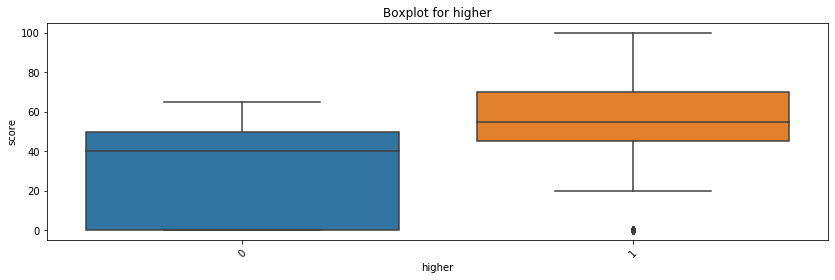

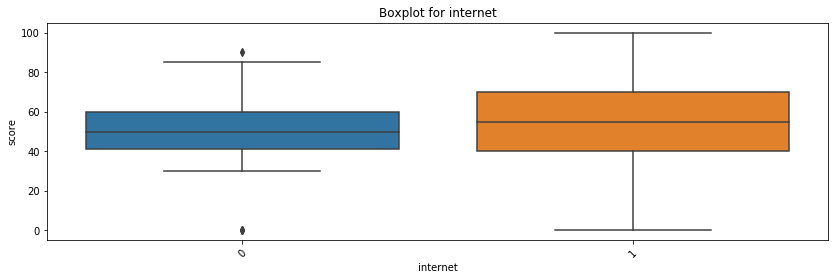

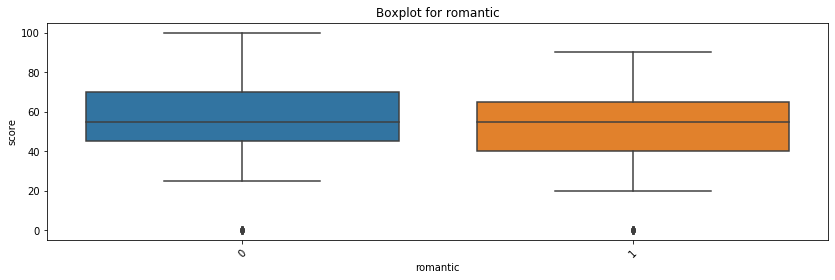

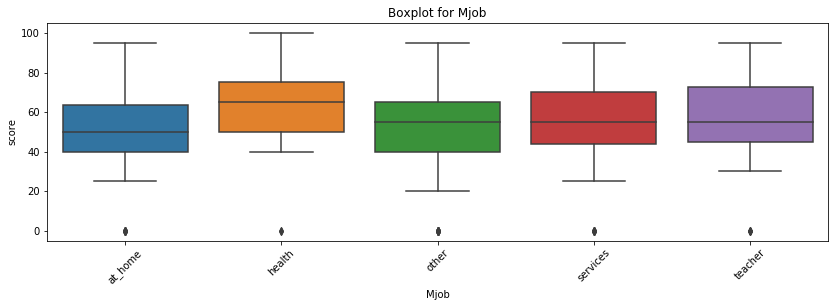

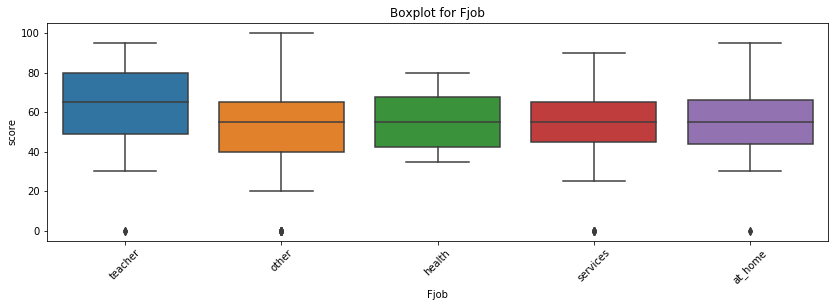

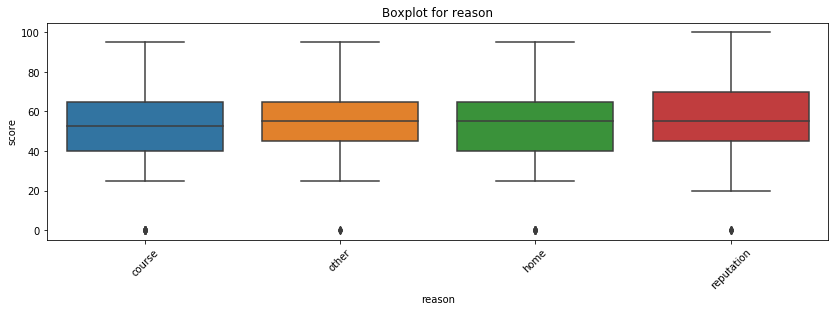

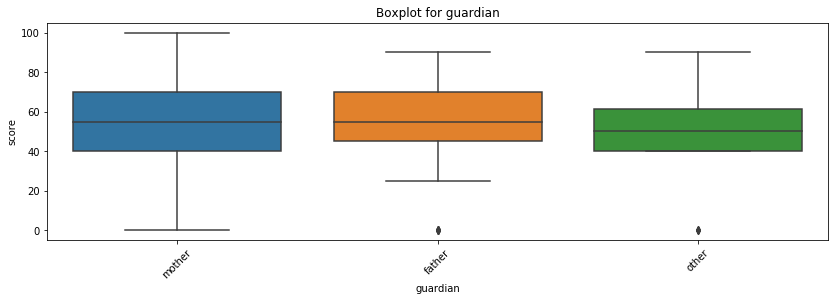

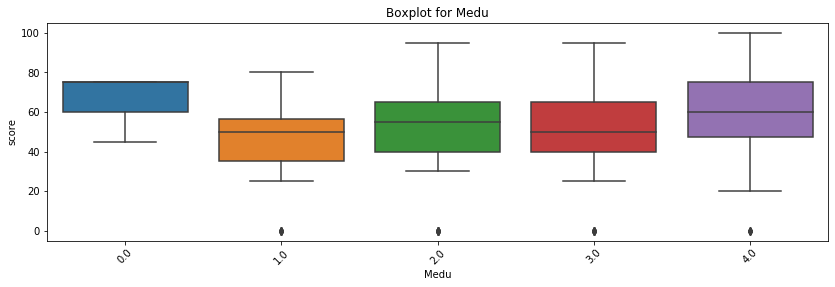

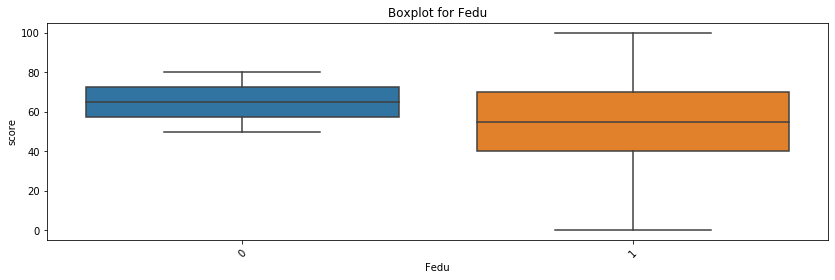

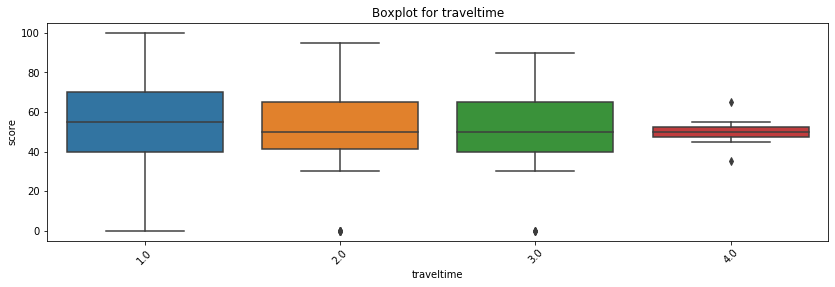

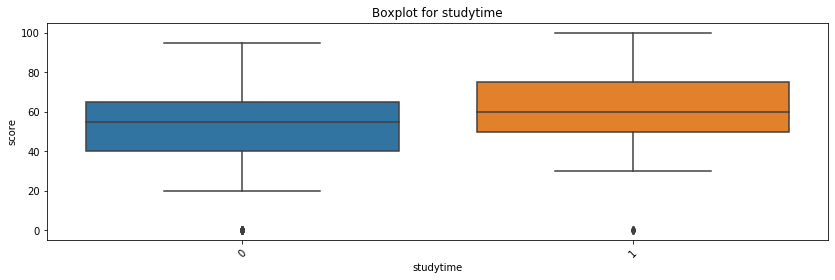

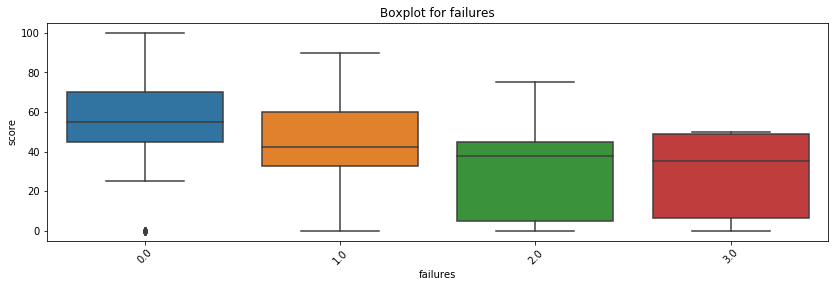

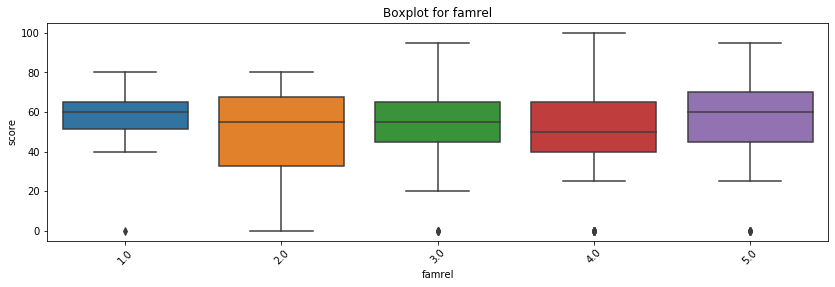

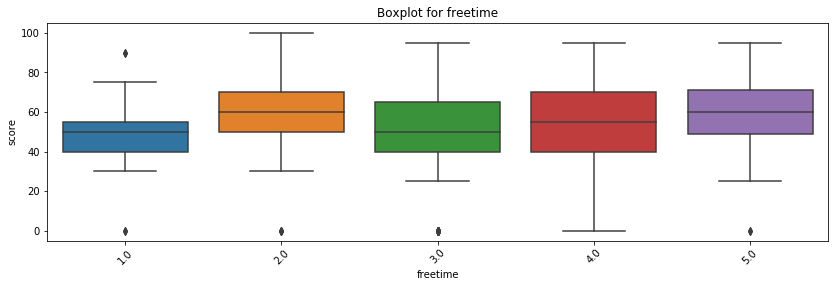

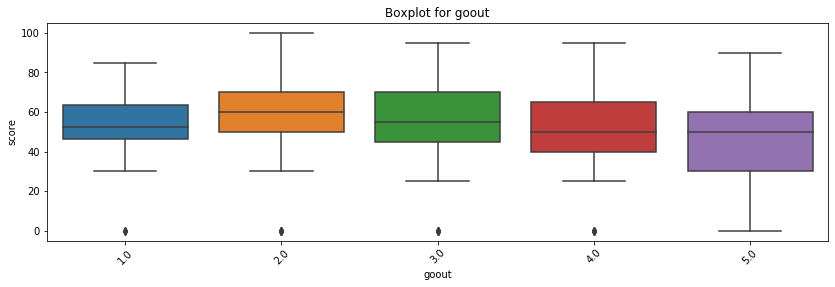

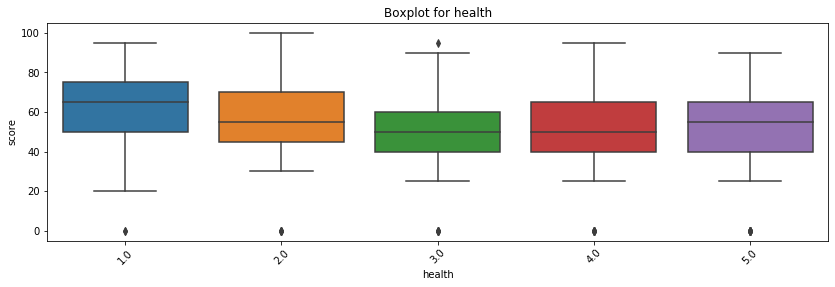

In [1756]:
for col in nominative_columns:
    get_boxplot(col)

По графикам похоже, что все параметры, кроме school, famsup, internet, reason и treveltime, могут влиять на баллы. Однако графики являются лишь вспомогательным инструментом, настоящую значимость различий может помочь распознать статистика. 

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения баллов за экзамен по различным параметрам неразличимы:

In [1757]:
for col in nominative_columns:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures


Как мы видим, серьёзно отличаются 9 параметров. Оставим эти переменные в датасете для дальнейшего построения модели. 

Добавим к ним числовые: age и absences.

И еще раз посмотрим на оставщиеся (та как, наверно, не правильно принимать решение на основании одного теста):

- school. Даже по графикам видно, что она не влияет на распределение баллов. Удалим из датасета.
- famsize. Не подходит по статистике, но не так очевидно плоха по графику. Я бы оставила до обучения, и дальше, в зависимости от важности признака для модели (если можно оценить) и результатов обучения с ней и без нее приняла решение.
- Pstatus. Не подходит по статистике + Процент значения A(0) в данных составляет всего 9% + Пропуски 12%. Удалим.
- schoolsup. Подходит по статистике, со значимостью 10%. Оставим до обучения, по результатам примем решение.
- famsup. Даже по графикам видно, что она не влияет на распределение. Удалим. 
- activities. Признак распределен почти равномерно, пропусков мало, но значимости нет. Удалим. 
- internet. Даже по графикам видно, что она не влияет на распределение. Удалим.
- Fjob. Не подходит по статистике + Большой процент значения "other" в данных. Удалим.
- reason. Даже по графикам видно, что она не влияет на распределение. Удалим.
- guardian. Не подходит по статистике + Большой процент значения "mother" в данных. Удалим. 
- Fedu. Не подходит по статистике, но если разбить признак только на 2 значения: есть образование - нет образования, то по графику различие становится более существенным. Оставляем до обучения, смотрим на важность.
- traveltime. Даже по графикам видно, что она не влияет на распределение. Удалим.
- studytime, granular. Удаляем, потому что копия studytime. 
- freetime. По статистике не подходит, но по графику все не так очевидно. Оставляем до обучения, смотрим на важность и результаты обучения.
- health. По статистике не подходит, по графику тоже все ровно. Удаляем.

Итак, в нашем случае важные переменные, которые, возможно, оказывают влияние на оценку, это:


In [1758]:
columns_for_model = ['age', 'absences', 'sex', 'address', 'famsize', 'schoolsup',
                     'paid', 'higher', 'romantic', 'Mjob', 'Medu', 'Fedu', 'studytime',
                     'failures', 'freetime', 'goout', 'score']
math_for_model = math.loc[:, columns_for_model]
math_for_model.head()

,age,absences,sex,address,famsize,schoolsup,paid,higher,romantic,Mjob,Medu,Fedu,studytime,failures,freetime,goout,score
0,18,6.0,0,0,1,1,0,1,0,at_home,4.0,1,0,0.0,3.0,4.0,30.0
1,17,4.0,0,0,0,0,0,1,0,at_home,1.0,1,0,0.0,3.0,3.0,30.0
2,15,10.0,0,0,1,1,0,1,0,at_home,1.0,1,0,3.0,3.0,2.0,50.0
3,15,2.0,0,0,0,0,1,1,1,health,4.0,1,1,0.0,2.0,2.0,75.0
4,16,4.0,0,0,0,0,1,1,0,other,3.0,1,0,0.0,3.0,2.0,50.0


In [1759]:
# Перекодируем признак Mjob
math_for_model = pd.get_dummies(math_for_model, columns=['Mjob',], dummy_na=False)
math_for_model.head()

,age,absences,sex,address,famsize,schoolsup,paid,higher,romantic,Medu,Fedu,studytime,failures,freetime,goout,score,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher
0,18,6.0,0,0,1,1,0,1,0,4.0,1,0,0.0,3.0,4.0,30.0,1,0,0,0,0
1,17,4.0,0,0,0,0,0,1,0,1.0,1,0,0.0,3.0,3.0,30.0,1,0,0,0,0
2,15,10.0,0,0,1,1,0,1,0,1.0,1,0,3.0,3.0,2.0,50.0,1,0,0,0,0
3,15,2.0,0,0,0,0,1,1,1,4.0,1,1,0.0,2.0,2.0,75.0,0,1,0,0,0
4,16,4.0,0,0,0,0,1,1,0,3.0,1,0,0.0,3.0,2.0,50.0,0,0,1,0,0


### Выводы

Итак, в результате EDA для анализа влияние условий жизни учащихся на их успеваемость по математике были получены следующие выводы:

- В данных достаточно мало пустых значений.
- Выбросы найдены только в столбцах Fedu, famrel и absences, что позволяет сделать вывод о том, что данные достаточно чистые.
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это 'age', 'absences', 'sex', 'address', 'paid', 'higher', 'romantic', 'Mjob', 'Medu', 'studytime', 'failures' и 'goout'. Еще предлагается проверить значимость парметров 'famsize', 'schoolsup', 'Fedu', 'freetime' по результатам обучения модели.
- Заполнение пропусков было выполнено во всех столбцах, но рекомендуется проверить и другие способы (указана для каждого признака отдельно) при обучении конкретной модели.
- Рекомендуется проверить другие способы обработки выбросов признака absences (удаление большего количества значений) при обучении конкретной модели.